# How to create a cumulative PL calculation

Last tested version: <img src="https://img.shields.io/badge/Atoti-v0.9.5-blue">

In this notebook, we'll illustrate cumulative PL calculation. In our example, the [rate-of-return](https://www.investopedia.com/terms/r/rateofreturn.asp) will accumulate over time according to the following formulae:

$$ Cumulative\ RoC = \prod_{start\_date}^{end\_date}\left ( 1+RoR \right )-1 $$ 

This formula will recalculate automatically for every scope of data we'll add into the view.

![Interactive RoR BI](interactive-ror.gif)

The example can be adjusted, for example, instead of product you can use summation over time, and the daily measure can be any profit-and-loss metric that you could think of. 

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=github-cumulative-pnl" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Try Atoti"></a></div>

In [1]:
import atoti as tt

In [2]:
session = tt.Session.start(tt.SessionConfig(user_content_storage="./content"))
positions = session.read_csv(
    "s3://data.atoti.io/notebooks/cumulative-pnl/positions.csv",
    table_name="positions",
    keys=[
        "AsOfDate",
        "Portfolio ID",
        "Real Asset ID",
        "Instrument ID",
        "Portfolio Type",
    ],
    data_types={"AsOfDate": tt.type.LOCAL_DATE},
    date_patterns={"AsOfDate": "dd-MM-yyyy"},
)

positions.head()

Size  \
AsOfDate   Portfolio ID  Real Asset ID Instrument ID      Portfolio Type          
2020-03-30 bm_02_01_1_a  ra_02_01_1    INE016A01026_sn5o7 Benchmark        6396   
           ra_01_02_3    ra_01_02_3    CH0238053125_l2ddb Real Asset       6488   
           bm_03_05_12_c ra_03_05_12   KYG8586D1097_mpfv3 Benchmark        7036   
2020-03-05 ra_02_01_13   ra_02_01_13   CH0127860192_fahbd Real Asset       5760   
           a_01_03_7_c   ra_01_03_7    KYG8586D1097_mpfv3 Active          -5301   

                                                                          Investment  \
AsOfDate   Portfolio ID  Real Asset ID Instrument ID      Portfolio Type               
2020-03-30 bm_02_01_1_a  ra_02_01_1    INE016A01026_sn5o7 Benchmark            660.9   
           ra_01_02_3    ra_01_02_3    CH0238053125_l2ddb Real Asset          -346.0   
           bm_03_05_12_c ra_03_05_12   KYG8586D1097_mpfv3 Benchmark            375.7   
2020-03-05 ra_02_01_13   ra_02_01_13   CH0127860192_fahbd Real Asset           491.0   
           a_01_03_7_c   ra_01_03_7    KYG8586D1097_mpfv3 Active              -452.9   

                                                                          Profit-and-loss  
AsOfDate   Portfolio ID  Real Asset ID Instrument ID      Portfolio Type                   
2020-03-30 bm_02_01_1_a  ra_02_01_1    INE016A01026_sn5o7 Benchmark                 1.825  
           ra_01_02_3    ra_01_02_3    CH0238053125_l2ddb Real Asset                1.074  
           bm_03_05_12_c ra_03_05_12   KYG8586D1097_mpfv3 Benchmark                 1.636  
2020-03-05 ra_02_01_13   ra_02_01_13   CH0127860192_fahbd Real Asset               -0.773  
           a_01_03_7_c   ra_01_03_7    KYG8586D1097_mpfv3 Active                    0.456

In [3]:
instrument_attributes = session.read_csv(
    "s3://data.atoti.io/notebooks/cumulative-pnl/instrument_attributes.csv",
    table_name="instrument_attributes",
    keys=["Instrument ID"],
)

instrument_attributes.head()

,Instrument Name,Instrument Currency,Instrument Type,Issuer,Country,Coupon,Yield,Maturity Date,Issue Date
Instrument ID,,,,,,,,,
KYG3066L1014_x3ru6,ENN Energy (ex Xinao Gas),HKD,Shares,N/A,Hong Kong,<NA>,<NA>,1970-01-01,1970-01-01
HK0000069689_uhvfx,AIA Group Ltd,HKD,Shares,N/A,Hong Kong,<NA>,<NA>,1970-01-01,1970-01-01
MXP4948K1056_nlg6w,Gruma Sa De Cv B,MXN,Shares,N/A,Mexico,<NA>,<NA>,1970-01-01,1970-01-01
US37949E2046_zdrd3,Globaltrans Investment Plc Gdr,USD,Shares,N/A,Cyprus,<NA>,<NA>,1970-01-01,1970-01-01
USG8189YAB05_yshk7,SINOPEC GR.O.D. 12/22REGS,USD,Bonds,Sinopec Group Overseas Development [2012] Ltd.,Virgin Islands,3.9,2.4,2022-05-17,2012-05-17


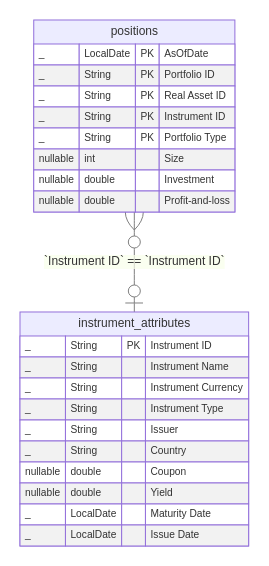

In [4]:
cube = session.create_cube(positions, mode="auto")
h, l, m = cube.hierarchies, cube.levels, cube.measures

positions.join(instrument_attributes)
session.tables.schema

In [5]:
m["Daily ROR"] = m["Profit-and-loss.SUM"] / m["Investment.SUM"]
m["Daily ROR"].formatter = "DOUBLE[#,##0.000%]"

m["Daily ROR + 1"] = m["Daily ROR"] + 1
m["Daily ROR + 1"].formatter = "DOUBLE[#,##0.0000]"

In [6]:
cube.create_date_hierarchy(
    "Calendar",
    column=positions["AsOfDate"],
    levels={"Year": "Y", "Month": "MMMM", "Day": "d"},
)
h["Calendar"].slicing = True

In [7]:
cube.levels["Month"].order = tt.CustomOrder(
    first_elements=[
        "January",
        "February",
        "March",
        "April",
        "May",
        "June",
        "July",
        "August",
        "September",
        "October",
        "November",
        "December",
    ]
)

In [8]:
m["Since Inception ROR"] = (
    tt.agg.prod(
        m["Daily ROR + 1"],
        scope=tt.CumulativeScope(level=l["Day"]),
    )
    - 1
)
m["Since Inception ROR"].formatter = "DOUBLE[#,##0.000%]"

m["MtD ROR"] = tt.where(
    ~l["Day"].isnull(),
    (
        tt.agg.prod(
            m["Daily ROR + 1"],
            scope=tt.CumulativeScope(level=l["Day"], partitioning=l["Month"]),
        )
        - 1
    ),
)
m["MtD ROR"].formatter = "DOUBLE[#,##0.000%]"

m["YtD ROR"] = tt.where(
    ~l["Day"].isnull(),
    (
        tt.agg.prod(
            m["Daily ROR + 1"],
            scope=tt.CumulativeScope(level=l["Day"], partitioning=l["Year"]),
        )
        - 1
    ),
)
m["YtD ROR"].formatter = "DOUBLE[#,##0.000%]"

In [9]:
session.link

http://localhost:62569

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=github-cumulative-pnl" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Try Atoti"></a></div>